In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torcheval.metrics.functional import word_error_rate
from torch.utils.data import DataLoader, Dataset

plt.style.use('ggplot')
import os
import pandas as pd
from tqdm import tqdm 

In [62]:
info = torch.load("/home/m33murra/test_vocal/26_model_final.torch",map_location="cpu")

/tmp/ipykernel_649753/2951266622.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  info = torch.load("/home/m33murra/test_vocal/26_model_final.torch",map_location="cpu")


In [63]:
info.keys()

dict_keys(['state_dict', 'train_losses', 'valid_losses'])

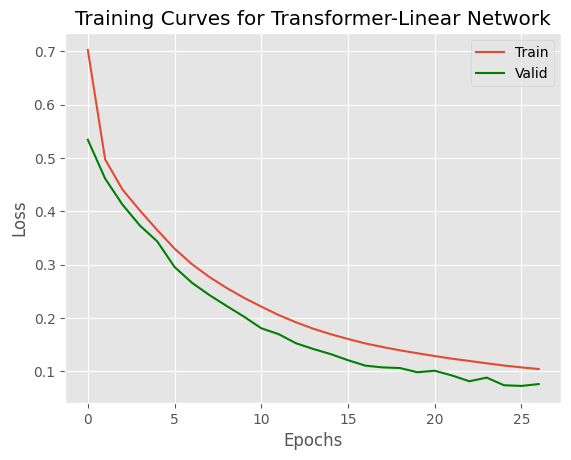

In [64]:
plt.clf()
plt.plot(info['train_losses'],label="Train")
plt.plot(info['valid_losses'],color='green',label="Valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Curves for Transformer-Linear Network")
plt.legend()
plt.show()

In [65]:
## Run the model on a sample

class GreedyCTCDecoder(torch.nn.Module): # from pytorch docs
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])


In [66]:
#Load the model
class simple_transformer_v2(nn.Module):
    def __init__(self, nheads=4, d_model=768, num_layers=4) -> None:
        super().__init__()
        bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
        self.sr = bundle.sample_rate
        self.labels = bundle.get_labels()

        self.num_chars = len(self.labels)
        self.ƒ = bundle.get_model().extract_features # Just want the feature extractor


        self.linear = nn.Linear(768,d_model) 
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model,nhead=nheads,batch_first=True),
            num_layers=num_layers
        )

        self.char_out = nn.Linear(768,self.num_chars)
    
    def forward(self,x):
        mask = simple_transformer_v2.create_mask(x)
        #x = self.linear(x)
        #x[x==PAD_IDX] = 0
        x = self.transformer(x,src_key_padding_mask = mask)
        x = self.char_out(x)
        return F.log_softmax(x, dim=-1)
    
    def create_mask(x, PAD_IDX = -9999):
        #x[:,100:] = PAD_IDX
        return ~(x!=PAD_IDX)[:,:,0] #false means use, true is ignore

class simple_transformer_v3(nn.Module):
    def __init__(self, nheads=4, d_model=768, num_layers=4) -> None:
        super().__init__()
        bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
        self.sr = bundle.sample_rate
        self.labels = bundle.get_labels()

        self.num_chars = len(self.labels)
        self.ƒ = bundle.get_model().extract_features # Just want the feature extractor

        
        self.linear = nn.Linear(768,d_model) 
        self.linear.weight = bundle.get_model().aux.weight
        for param in self.linear.parameters():
            param.requires_grad = False
            
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model,nhead=nheads,batch_first=True),
            num_layers=num_layers
        )

        self.char_out = nn.Linear(768,self.num_chars)
    
    def forward(self,x):
        mask = simple_transformer_v3.create_mask(x)
        #x = self.linear(x)
        #x[x==PAD_IDX] = 0
        x = self.transformer(x,src_key_padding_mask = mask)
        x = self.char_out(x)
        return F.log_softmax(x, dim=-1)
    
    def create_mask(x, PAD_IDX = -9999):
        #x[:,100:] = PAD_IDX
        return ~(x!=PAD_IDX)[:,:,0] #false means use, true is ignore
        #return x==PAD_IDX


class simple_converter_from_literature(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
        self.sr = bundle.sample_rate
        self.labels = bundle.get_labels()
        self.num_chars = len(self.labels)
        self.ƒ = bundle.get_model().extract_features # Just want the feature extractor
        self.bundle = bundle
        self.linear = nn.Linear(768, self.num_chars) #29
        self.linear.weight = bundle.get_model().aux.weight 
    
    def forward(self,x):
        x = self.linear(x)
        return F.log_softmax(x, dim=-1)

model = simple_transformer_v3()
model.load_state_dict(info['state_dict'])
model.eval()

simple_transformer_v3(
  (linear): Linear(in_features=768, out_features=768, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (char_out): Linear(in_features=768, out_features=29, bias=True)
)

In [67]:
waveform, sample_rate = torchaudio.load("/home/m33murra/test_vocal/i am ran to the bus.wav")#CONC copy.wav")

if sample_rate != model.sr:
    waveform = torchaudio.functional.resample(waveform, sample_rate, model.sr)
model.eval()
with torch.inference_mode():
    latent, _ = model.ƒ(waveform)
    emission = model(latent[-1])

/home/m33murra/miniconda/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


In [68]:
waveform.shape

torch.Size([1, 40278])

In [69]:
latent[-1].shape

torch.Size([1, 125, 768])

In [70]:
emission.shape

torch.Size([1, 125, 29])

In [71]:
greedyDecoder = GreedyCTCDecoder(labels=model.labels)
transcript = greedyDecoder(emission[0])

In [72]:
## Run WER on test set


flac_files = []
labels_files = []

for dir in os.listdir("kaggle/input/librispeech-clean/LibriSpeech/test-clean"):
    for file in os.listdir(os.path.join("kaggle/input/librispeech-clean/LibriSpeech/test-clean",dir)):
        for file_d in os.listdir(os.path.join("kaggle/input/librispeech-clean/LibriSpeech/test-clean",dir,file)):
            if file_d.endswith(".flac"):
                flac_files.append(os.path.join("kaggle/input/librispeech-clean/LibriSpeech/test-clean",dir,file,file_d))
            if file_d.endswith(".txt"):
                labels_files.append(os.path.join("kaggle/input/librispeech-clean/LibriSpeech/test-clean",dir,file,file_d))
        
#df = pd.DataFrame()
dirs = []
all_labels = []
for labels in labels_files:
    #data = pd.read_csv(f'{labels}')
    #df = pd.concat([df,data])
    with open(labels, "r") as file:
        lines = file.readlines()

    lines = [line.strip("\n") for line in lines]
    for j in range(len(lines)):
        dirs.append(labels)
    all_labels.extend(lines)
ids = [x.split(" ")[0] for x in all_labels]
true_labels = [" ".join(x.split(" ")[1:]) for x in all_labels]

flac_dict = {flac.split("/")[-1].split(".flac")[0]: flac for flac in flac_files}

organized_flac = []
for id in tqdm(ids):
    if id in flac_dict:
        organized_flac.append(flac_dict[id])
    else:
        print("ERROR")
df = pd.DataFrame()
df["dir"] = organized_flac
df["ids"] = ids
df["labels"] = true_labels


100%|██████████| 2620/2620 [00:00<00:00, 6108436.06it/s]


In [73]:
class DataSet(Dataset):
    def __init__(self, local_df, encoder, decoder):
        self.df = local_df
        self.sr = decoder.sr
        self.decoder = decoder
        self.encoder = encoder
    def __getitem__(self, index):
        
        dir = self.df.iloc[index].dir
        ids = self.df.iloc[index].ids
        labels = self.df.iloc[index].labels
        labels = labels.replace("","-")
        labels = labels.replace(" ","|")
        #print(labels)
        char_to_idx = {char: idx for idx, char in enumerate(self.decoder.labels)}
        ground_truth_token = torch.tensor([char_to_idx[c] for c in labels])

        waveform, sample_rate = torchaudio.load(dir)
          

        if sample_rate != self.decoder.sr:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.decoder.sr)

        with torch.no_grad():
            latent, _ = self.encoder(waveform)
        
        latent = latent[-1].squeeze()
        return latent, ground_truth_token
         
    def __len__(self):
        return len(self.df)

In [74]:
from torch.nn.utils.rnn import pad_sequence
PAD_IDX = -9999

def collate_fn(batch):
    latents, labels = zip(*batch)

    latents_padded = pad_sequence(latents, batch_first=True, padding_value=PAD_IDX)
    #print(latents.shape)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1)

    return latents_padded, labels_padded

In [75]:
dataset = DataSet(df,model.ƒ,model)
dl = DataLoader(dataset, batch_size=2, shuffle=False, collate_fn=collate_fn) #16

In [76]:
model.eval()

simple_transformer_v3(
  (linear): Linear(in_features=768, out_features=768, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (char_out): Linear(in_features=768, out_features=29, bias=True)
)

In [77]:
errs = 0
tots = 0
for j, (latents, labels) in enumerate(tqdm(dl)):
    with torch.no_grad():
        model.eval()
    
        labels = labels.squeeze()
        prediction = model(latents)

        greedyDecoder = GreedyCTCDecoder(labels=model.labels)
        result_str_greedy = greedyDecoder(prediction[0]).replace("|"," ")

        prediction = prediction.permute(1, 0, 2)  

        #visual reasons
        max_indices = torch.argmax(prediction, dim=2)
        result_str = "".join([model.labels[idx] for idx in max_indices[:,0]])
        result_str = result_str.replace("-", "").replace("|", " ")

        labels[labels==-1] = 0
        gt_string = "".join([model.labels[idx] for idx in labels[0]])
        gt_string = gt_string.replace("-", "").replace("|", " ")

        max_gt = len(gt_string)

        if j < 50:
            print("-------")
            print(result_str[:max_gt])
            print(result_str_greedy[:max_gt])
            print(gt_string)
            print("-------")

        errs += word_error_rate(result_str_greedy,gt_string)
        tots += 1
        
        target_lengths = torch.tensor([len(lbl[lbl != -1]) for lbl in labels], dtype=torch.long)
        #input_lengths = torch.tensor([prediction.size(0)] * prediction.size(1), dtype=torch.long).to(device)
        input_lengths = torch.tensor([l[l!=PAD_IDX].view(-1,768).shape[0] for l in latents])
        #flattened_labels = torch.tensor([lbl[lbl != -1] for lbl in labels])

  0%|          | 2/1310 [00:00<04:11,  5.21it/s]

-------
HE HOPDERE WOULD BE STEW FOR DINNNER TURNIPS ANDD CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOWER FAT ANDD SAUCE
HE HOPDERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOWER FAT AND SAUCE
HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE
-------
-------
AFTER EARLY NIGHTFALL THE YELLOW AMPS WOULD LLIGHT UP HERE AAND THERE THE SQUALIID QUARTER OF THEE BROTH
AFTER EARLY NIGHTFALL THE YELLOW AMPS WOULD LIGHT UP HERE AND THERE THE SQUALID QUARTER OF THE BROTHELS
AFTER EARLY NIGHTFALL THE YELLOW LAMPS WOULD LIGHT UP HERE AND THERE THE SQUALID QUARTER OF THE BROTHELS
-------


  0%|          | 3/1310 [00:00<04:27,  4.89it/s]

-------
NUUMBERRTEN RRESHNELLY IS WAITING ON YOU GOODNIGHT HUSBAND 
NUMBERTEN RRESHNELLY IS WAITING ON YOU GOODNIGHT HUSBAND 
NUMBER TEN FRESH NELLY IS WAITING ON YOU GOOD NIGHT HUSBAND
-------


  0%|          | 4/1310 [00:00<04:35,  4.74it/s]

-------
THE  DULL LIGHT FELL MORE FAINTLY UPON THE PAGE WHEREON ANOTHER EQUATION BEGAN TO UNFOLD ITSELF SLOWLY AND TO SPPREAD ABROAD ITS WIDENINGG T
THE DULL LIGHT FELL MORE FAINTLY UPON THE PAGE WHEREON ANOTHER EQUATION BEGAN TO UNFOLD ITSELF SLOWLY AND TO SPREAD ABROAD ITS WIDENING TAIL
THE DULL LIGHT FELL MORE FAINTLY UPON THE PAGE WHEREON ANOTHER EQUATION BEGAN TO UNFOLD ITSELF SLOWLY AND TO SPREAD ABROAD ITS WIDENING TAIL
-------


  0%|          | 5/1310 [00:01<04:57,  4.39it/s]

-------
THE CHAOS IN WHICH HIS ARDOR EXTIINGUISHED ITSELF WAS A COLD INDIIFFERENT KNOWLEDGE OF HIMSEL
THE CHAOS IN WHICH HIS ARDOR EXTINGUISHED ITSELF WAS A COLD INDIFFERENT KNOWLEDGE OF HIMSELF 
THE CHAOS IN WHICH HIS ARDOUR EXTINGUISHED ITSELF WAS A COLD INDIFFERENT KNOWLEDGE OF HIMSELF
-------


  0%|          | 6/1310 [00:01<05:12,  4.18it/s]

-------
WEL NOW ENIS I DECLARE YOU HAVE A HEAD AND SO HAS MY STICK  
WEL NOW ENIS I DECLARE YOU HAVE A HEAD AND SO HAS MY STICK 
WELL NOW ENNIS I DECLARE YOU HAVE A HEAD AND SO HAS MY STICK
-------


  1%|          | 8/1310 [00:01<04:49,  4.50it/s]

-------
HR EYYES SEEEMED TO REGARD HIM WITH MILD PITY HER HOLINESS A  STRANNGE LIGHT GLOWING FFAINTLY UPON HER FRAIL FLESH DID NOT HUMILIATE THESINNER HO APPROACHED H
HR EYES SEEMED TO REGARD HIM WITH MILD PITY HER HOLINESS A STRANGE LIGHT GLOWING FAINTLY UPON HER FRAIL FLESH DID NOT HUMILIATE THESINNER HO APPROACHED HER
HER EYES SEEMED TO REGARD HIM WITH MILD PITY HER HOLINESS A STRANGE LIGHT GLOWING FAINTLY UPON HER FRAIL FLESH DID NOT HUMILIATE THE SINNER WHO APPROACHED HER
-------
-------
HE TRIED TO THINK HOW IT COUULD B
HE TRIED TO THINK HOW IT COULD BE
HE TRIED TO THINK HOW IT COULD BE
-------


  1%|          | 9/1310 [00:01<04:36,  4.71it/s]

-------
THEEEN YOU CAN ASK HIM QUESTIONS ON THE CATECHISM DEDAL
THEN YOU CAN ASK HIM QUESTIONS ON THE CATECHISM DEDALUS
THEN YOU CAN ASK HIM QUESTIONS ON THE CATECHISM DEDALUS
-------


  1%|          | 10/1310 [00:02<06:01,  3.60it/s]

-------
 WWAS STRANGE TOO THT HE FOUND AN ARID PLEASURE IN FOLLOWING UP TO THE END THE RIGID LINES OF THE DOCTRINES OF THE CHURCH AND PENETRATING INTO OBSCURE SILENCES ONNLY TO HEAR AND FEEL THE MORE DEEPLY HIS OWN CONDEMNATIONN
 WAS STRANGE TOO THT HE FOUND AN ARID PLEASURE IN FOLLOWING UP TO THE END THE RIGID LINES OF THE DOCTRINES OF THE CHURCH AND PENETRATING INTO OBSCURE SILENCES ONLY TO HEAR AND FEEL THE MORE DEEPLY HIS OWN CONDEMNATION
IT WAS STRANGE TOO THAT HE FOUND AN ARID PLEASURE IN FOLLOWING UP TO THE END THE RIGID LINES OF THE DOCTRINES OF THE CHURCH AND PENETRATING INTO OBSCURE SILENCES ONLY TO HEAR AND FEEL THE MORE DEEPLY HIS OWN CONDEMNATION
-------


  1%|          | 11/1310 [00:02<06:30,  3.32it/s]

-------
IF A MAN HAD STOLEN A POUND IN HIS YOUTH AND HAD UUSED THAT POUND TO A MASS A HUGE FORTUNE  HHOOW MUCH WAS HE OBLIGED TO GIVVE BACK THE POUNND HE HAD STOLEN ONLY OR THE POUND TOGEETHER WITH TTHE COMPOUND INTEREST A CRUWING UPON IT OOR ALL HISS 
IF A MAN HAD STOLEN A POUND IN HIS YOUTH AND HAD USED THAT POUND TO A MASS A HUGE FORTUNE HOW MUCH WAS HE OBLIGED TO GIVE BACK THE POUND HE HAD STOLEN ONLY OR THE POUND TOGETHER WITH THE COMPOUND INTEREST A CRUWING UPON IT OR ALL HIS HUGE FORTU
IF A MAN HAD STOLEN A POUND IN HIS YOUTH AND HAD USED THAT POUND TO AMASS A HUGE FORTUNE HOW MUCH WAS HE OBLIGED TO GIVE BACK THE POUND HE HAD STOLEN ONLY OR THE POUND TOGETHER WITH THE COMPOUND INTEREST ACCRUING UPON IT OR ALL HIS HUGE FORTUNE
-------


  1%|          | 12/1310 [00:03<06:45,  3.20it/s]

-------
HHW COMES I  THAT WHILE THE FIRST BBEATITUDE PROMISES THE  KINDOOM OF HEAVEN TO THE POOR OF HEAART THE SECOND BEATITUDE PRMISE ALSO TO THE MEEK THAT THHEY SHALL POSSESS THE LA
HHW COMES I  THAT WHILE THE FIRST BEATITUDE PROMISES THE KINDOM OF HEAVEN TO THE POOR OF HEART THE SECOND BEATITUDE PRMISE ALSO TO THE MEEK THAT THEY SHALL POSSESS THE LAND 
HOW COMES IT THAT WHILE THE FIRST BEATITUDE PROMISES THE KINGDOM OF HEAVEN TO THE POOR OF HEART THE SECOND BEATITUDE PROMISES ALSO TO THE MEEK THAT THEY SHALL POSSESS THE LAND
-------


  1%|          | 14/1310 [00:03<05:22,  4.02it/s]

-------
IF THE WINE CHANGE INTO VINEGAR ANND THE HOST CRUMBLE INTO CORRPTION AFTER THEY HAVE BEEN CONSECRAATED IS JJESUS CHRRIST STILL PRESENT  UUNDER THEIR SPECIIES AS GOD AND 
IF THE WINE CHANGE INTO VINEGAR AND THE HOST CRUMBLE INTO CORRPTION AFTER THEY HAVE BEEN CONSECRATED IS JESUS CHRIST STILL PRESENT UNDER THEIR SPECIES AS GOD AND AS MAN
IF THE WINE CHANGE INTO VINEGAR AND THE HOST CRUMBLE INTO CORRUPTION AFTER THEY HAVE BEEN CONSECRATED IS JESUS CHRIST STILL PRESENT UNDER THEIR SPECIES AS GOD AND AS MAN
-------
-------
THE RECTOR DI NOT ASK FOR A CATECHISM TO HEAR THE LESSON FROM
THE RECTOR DI NOT ASK FOR A CATECHISM TO HEAR THE LESSON FROM
THE RECTOR DID NOT ASK FOR A CATECHISM TO HEAR THE LESSON FROM
-------


  1%|          | 16/1310 [00:03<04:35,  4.69it/s]

-------
THE RETREAT WILL BEGINN ON WEDESDAY AFTERNOON IN HONOR OF SAINT FRANCIS  ZAVIER WHOSE FEASST DDAY  IS SATUR
THE RETREAT WILL BEGIN ON WEDESDAY AFTERNOON IN HONOR OF SAINT FRANCIS ZAVIER WHOSE FEAST DAY IS SATURDAY
THE RETREAT WILL BEGIN ON WEDNESDAY AFTERNOON IN HONOUR OF SAINT FRANCIS XAVIER WHOSE FEAST DAY IS SATURDAY
-------
-------
BEWARE OFF MAKING THAT MISTAK
BEWARE OF MAKING THAT MISTAKE
BEWARE OF MAKING THAT MISTAKE
-------


  1%|▏         | 18/1310 [00:04<03:49,  5.63it/s]

-------
H IS CALLED AS YOU KNOW THE  APOSTLE OF THE INDIES
H IS CALLED AS YOU KNOW THE APOSTLE OF THE INDIES
HE IS CALLED AS YOU KNOW THE APOSTLE OF THE INDIES
-------
-------
THE RECTOR PAUSED AND THEN SHAKKING HIS CLASPEED HANDS BEFORE HIM WENT 
THE RECTOR PAUSED AND THEN SHAKING HIS CLASPED HANDS BEFORE HIM WENT ON
THE RECTOR PAUSED AND THEN SHAKING HIS CLASPED HANDS BEFORE HIM WENT ON
-------


  2%|▏         | 20/1310 [00:04<03:23,  6.35it/s]

-------
A GREATT SAINTT SAINT FRANCISS ZAV
A GREAT SAINT SAINT FRANCIS ZAVIAR
A GREAT SAINT SAINT FRANCIS XAVIER
-------
-------
HE COULD WWAIIT NO LONG
HE COULD WAIT NO LONGER
HE COULD WAIT NO LONGER
-------


  2%|▏         | 22/1310 [00:04<03:45,  5.72it/s]

-------
HE SET OFF  ABRUPTLY FOR THE BULL WALKING RAPIDLY LEST HIS FATHER'S SHRILL WHISTLE MIGHT CCALL HIM BACK AND IN A FEW MOMENTS HE HAD ROUNDED THE CURVE AT THEE POLICE BARRACK AAND WAS 
HE SET OFF ABRUPTLY FOR THE BULL WALKING RAPIDLY LEST HIS FATHER'S SHRILL WHISTLE MIGHT CALL HIM BACK AND IN A FEW MOMENTS HE HAD ROUNDED THE CURVE AT THE POLICE BARRACK AND WAS SAFE
HE SET OFF ABRUPTLY FOR THE BULL WALKING RAPIDLY LEST HIS FATHER'S SHRILL WHISTLE MIGHT CALL HIM BACK AND IN A FEW MOMENTS HE HAD ROUNDED THE CURVE AT THE POLICE BARRACK AND WAS SAFE
-------
-------
PRIDE AFTTER SATISFACTION UPLIFTED HIM LIKE LONG SLOW WAVE
PRIDE AFTER SATISFACTION UPLIFTED HIM LIKE LONG SLOW WAVES
PRIDE AFTER SATISFACTION UPLIFTED HIM LIKE LONG SLOW WAVES
-------


  2%|▏         | 23/1310 [00:04<03:38,  5.88it/s]

-------
HHE PRIDE OF TTHAT DIM IMAGE BROOUGHT BACK TO HIS MIND THE DIGNITY OF THE OFFICE HE HAD REFFU
HHE PRIDE OF THAT DIM IMAGE BROUGHT BACK TO HIS MIND THE DIGNITY OF THE OFFICE HE HAD REFUSED
THE PRIDE OF THAT DIM IMAGE BROUGHT BACK TO HIS MIND THE DIGNITY OF THE OFFICE HE HAD REFUSED
-------


  2%|▏         | 24/1310 [00:05<05:48,  3.69it/s]

-------
HE UNCCOUUTH FACES PASSED HIM O BY TWO SSAINED YELLOW OOR RED OR LIVID BY THE SEA AAND AS HE STROVE TO LOOK AT  THEM WITH EASE AND INDIFFERENCE A FAINT STAIN OF PERSONAL SHAME AND COMMIISERATION ROSE TO HIS OWN F
HE UNCOUTH FACES PASSED HIM O BY TWO SAINED YELLOW OR RED OR LIVID BY THE SEA AND AS HE STROVE TO LOOK AT THEM WITH EASE AND INDIFFERENCE A FAINT STAIN OF PERSONAL SHAME AND COMMISERATION ROSE TO HIS OWN FACE 
THE UNCOUTH FACES PASSED HIM TWO BY TWO STAINED YELLOW OR RED OR LIVID BY THE SEA AND AS HE STROVE TO LOOK AT THEM WITH EASE AND INDIFFERENCE A FAINT STAIN OF PERSONAL SHAME AND COMMISERATION ROSE TO HIS OWN FACE
-------


  2%|▏         | 25/1310 [00:05<06:27,  3.32it/s]

-------
BRROTHEER MACCARDEL BROTHEER KI
BRROTHER MACARDEL BROTHER KIOF 
BROTHER MAC ARDLE BROTHER KEOGH
-------


  2%|▏         | 27/1310 [00:06<06:08,  3.48it/s]

-------
IT WAS IDLE FOR HIM TO MOVVE HIMSELF TO BE GENEROUS TOWARDS THIM O TELL HIMSELF  THAT IF HE EVEER CAME TO THEIR GATESS STRIPPED OFHHIS PRIIDE BEATEN AND  IN BEGGAARS WEEDDS  TAT  THEY WOULD BE GENEROUS TOWARDS HIM LOVIING HIM AS TH
IT WAS IDLE FOR HIM TO MOVE HIMSELF TO BE GENEROUS TOWARDS THIM O TELL HIMSELF THAT IF HE EVER CAME TO THEIR GATES STRIPPED OFHIS PRIDE BEATEN AND IN BEGGARS WEEDS TAT  THEY WOULD BE GENEROUS TOWARDS HIM LOVING HIM AS THEMSELVES 
IT WAS IDLE FOR HIM TO MOVE HIMSELF TO BE GENEROUS TOWARDS THEM TO TELL HIMSELF THAT IF HE EVER CAME TO THEIR GATES STRIPPED OF HIS PRIDE BEATEN AND IN BEGGAR'S WEEDS THAT THEY WOULD BE GENEROUS TOWARDS HIM LOVING HIM AS THEMSELVES
-------
-------
THE PHRASE AND THE  DAY AND THE SCENE HARMONIZED IN ACCOOR
THE PHRASE AND THE DAY AND THE SCENE HARMONIZED IN ACCORD
THE PHRASE AND THE DAY AND THE SCENE HARMONIZED IN A CHORD
-------


  2%|▏         | 29/1310 [00:06<05:00,  4.26it/s]

-------
THHEYWERE VOYAGING ACROSS THE DESERTS OF THE SSKY A HOST OF GNOMADS ON THEE MARCH VVOYAGING HIGH OVER IRELAND WESTWARD B
THHEYWERE VOYAGING ACROSS THE DESERTS OF THE SKY A HOST OF GNOMADS ON THE MARCH VOYAGING HIGH OVER IRELAND WESTWARD BOUN
THEY WERE VOYAGING ACROSS THE DESERTS OF THE SKY A HOST OF NOMADS ON THE MARCH VOYAGING HIGH OVER IRELAND WESTWARD BOUND
-------
-------
AGAINNN AGG
AGAIN AGAIN
AGAIN AGAIN
-------


  2%|▏         | 31/1310 [00:07<04:46,  4.46it/s]

-------
HEELLLO STEPHANOS  ERE COMES THE DEDAL
HELLO STEPHANOS  ERE COMES THE DEDALUS
HELLO STEPHANOS HERE COMES THE DEDALUS
-------
-------
HE  STOOD STILL IIN DEFEERENCE TO THEIR CALS AND PARRRIIED THEIR BANTER WITH EASY W
HE  STOOD STILL IN DEFERENCE TO THEIR CALS AND PARRIED THEIR BANTER WITH EASY WORDS
HE STOOD STILL IN DEFERENCE TO THEIR CALLS AND PARRIED THEIR BANTER WITH EASY WORDS
-------


  2%|▏         | 32/1310 [00:07<04:25,  4.82it/s]

-------
TEPHANOTEDLOS    
TEPHANOTEDLOS 
STEPHANOS DEDALOS
-------


  3%|▎         | 33/1310 [00:07<04:51,  4.38it/s]

-------
YOOU WILL FFIND ME CONTINUALLY SPEAKING OF FOUR MEN TITIAN HOOLBINE TURNERR  ANDTINTARET INN ALMOST THE SAME 
YOU WILL FIND ME CONTINUALLY SPEAKING OF FOUR MEN TITIAN HOLBINE TURNER ANDTINTARET INN ALMOST THE SAME TERMS
YOU WILL FIND ME CONTINUALLY SPEAKING OF FOUR MEN TITIAN HOLBEIN TURNER AND TINTORET IN ALMOST THE SAME TERMS
-------


  3%|▎         | 34/1310 [00:08<06:15,  3.40it/s]

-------
BY BEING STUDDIOS OF CCOLOR THEY ARE STUDOUS OF DIVISION AWHILLE THE CUROSCURUS DEVOTESS HIMSELF TO THHE REPRESENTATION OF  DEGRES OF FORCE AND ON THING UNSEPARRATED LIGHT THE COLORISTS HHAVEFFOR  THEIR FUNCTION TE ATTAINMENT  OF BEAUTY BY AARRRANNGEMENTT OF THE DIVISIONNS OF 
BY BEING STUDIOS OF COLOR THEY ARE STUDOUS OF DIVISION AWHILLE THE CUROSCURUS DEVOTES HIMSELF TO THE REPRESENTATION OF DEGRES OF FORCE AND ON THING UNSEPARATED LIGHT THE COLORISTS HAVEFOR THEIR FUNCTION TE ATTAINMENT OF BEAUTY BY ARRANGEMENT OF THE DIVISIONS OF LIGHT
BY BEING STUDIOUS OF COLOR THEY ARE STUDIOUS OF DIVISION AND WHILE THE CHIAROSCURIST DEVOTES HIMSELF TO THE REPRESENTATION OF DEGREES OF FORCE IN ONE THING UNSEPARATED LIGHT THE COLORISTS HAVE FOR THEIR FUNCTION THE ATTAINMENT OF BEAUTY BY ARRANGEMENT OF THE DIVISIONS OF LIGHT
-------


  3%|▎         | 35/1310 [00:08<06:07,  3.47it/s]

-------
SOOMME  OFF THE TOUCHES INDEE WHEEN THETINT HAS BEEN MIXED WITH MUCHH WATER HAVE BEEN LAID IN LITTTLLE DROOPS OR PONDS SOTHA THE PIMENT MIGHT  CRYSTALLIZE HAD AT THEE
SOOME  OF THE TOUCHES INDEE WHEN THETINT HAS BEEN MIXED WITH MUCH WATER HAVE BEEN LAID IN LITTLE DROPS OR PONDS SOTHA THE PIMENT MIGHT CRYSTALLIZE HAD AT THE EDGE
SOME OF THE TOUCHES INDEED WHEN THE TINT HAS BEEN MIXED WITH MUCH WATER HAVE BEEN LAID IN LITTLE DROPS OR PONDS SO THAT THE PIGMENT MIGHT CRYSTALLIZE HARD AT THE EDGE
-------


  3%|▎         | 36/1310 [00:08<05:57,  3.56it/s]

-------
THHEN HE COMES TTO THE BEEAK OF
THEN HE COMES TO THE BEAK OF IT
THEN HE COMES TO THE BEAK OF IT
-------


  3%|▎         | 37/1310 [00:09<08:41,  2.44it/s]

-------
FFOR BELIEVE ME TTHHHE FINAL PHILOSOPHY OFART CAN ONLY RATIFY THEIR  OPINION THAT THE BEAUTY OF A COCK ROBIN IS TO BE REAT AND OF A GRASS PLOT TO BE GREEN ANNN TTH BES SKILL OF ART IS AN INSTANTLY SSEIZI OON THE MANIFOLD DELICIOUSNESS OF LIGHT HHIHH YOU CAN ONLY SEIZE BY PRECISION OOF INSSTANTANEOU
FFOR BELIEVE ME THE FINAL PHILOSOPHY OFART CAN ONLY RATIFY THEIR OPINION THAT THE BEAUTY OF A COCK ROBIN IS TO BE REAT AND OF A GRASS PLOT TO BE GREEN ANN TTH BES SKILL OF ART IS AN INSTANTLY SEIZI ON THE MANIFOLD DELICIOUSNESS OF LIGHT HIHH YOU CAN ONLY SEIZE BY PRECISION OF INSTANTANEOUS TOUCH 
FOR BELIEVE ME THE FINAL PHILOSOPHY OF ART CAN ONLY RATIFY THEIR OPINION THAT THE BEAUTY OF A COCK ROBIN IS TO BE RED AND OF A GRASS PLOT TO BE GREEN AND THE BEST SKILL OF ART IS IN INSTANTLY SEIZING ON THE MANIFOLD DELICIOUSNESS OF LIGHT WHICH YOU CAN ONLY SEIZE BY PRECISION OF INSTANTANEOUS TOUCH
-------


  3%|▎         | 38/1310 [00:09<08:06,  2.62it/s]

-------
BUU IN THIS VIGNET CCOPIEED FRROM TURNER YOOU HAVE THHE TWOO PRIINCIPES BROUGGHT OUUT PER
BUU IN THIS VIGNET COPIED FROM TURNER YOOU HAVE THE TWO PRINCIPES BROUGHT OUT PERFECTLY 
BUT IN THIS VIGNETTE COPIED FROM TURNER YOU HAVE THE TWO PRINCIPLES BROUGHT OUT PERFECTLY
-------


  3%|▎         | 39/1310 [00:10<07:22,  2.87it/s]

-------
IT MMAY BE THAT A GREAT COLORLESS WILL USE HISS UTMOST FORCE OF COLOOR AAS A SINGERR HIS FULL POWER OF VOICEBUT  LOOUD OOR LOW THHE VIRTUE IS IN BOTH CASES ALWAYS IN REFINEMENT NEVER IN
IT MAY BE THAT A GREAT COLORLESS WILL USE HIS UTMOST FORCE OF COLOOR AS A SINGER HIS FULL POWER OF VOICEBUT LOUD OR LOW THE VIRTUE IS IN BOTH CASES ALWAYS IN REFINEMENT NEVER IN LOUDNES
IT MAY BE THAT A GREAT COLORIST WILL USE HIS UTMOST FORCE OF COLOR AS A SINGER HIS FULL POWER OF VOICE BUT LOUD OR LOW THE VIRTUE IS IN BOTH CASES ALWAYS IN REFINEMENT NEVER IN LOUDNESS
-------


  3%|▎         | 40/1310 [00:10<07:18,  2.90it/s]

-------
DO NNOOT THEREFORE THHIINKTHAT THE GOTHIC SCHOOL IS AN EASY 
DO NOT THEREFORE THHINKTHAT THE GOTHIC SCHOOL IS AN EASY ONE
DO NOT THEREFORE THINK THAT THE GOTHIC SCHOOL IS AN EASY ONE
-------


  3%|▎         | 41/1310 [00:10<07:23,  2.86it/s]

-------
TTHIS AT ONCEE CCOMPELS  YOU TO UNDERSTAND THAT THE WORK IS TO BE IMAGINATIVE AND DDECORATVE TTHT  IT REEPRESEENTS BEAUTIFUL THINGS IN THE CLEAREST WAY BUT NOT UNDER EXISTING CONDITIOGS AAND THAAT IN FACT YOOUU AARE  PRODUCING JEWELLE''S WORK RTHER 
THIS AT ONCE COMPELS YOU TO UNDERSTAND THAT THE WORK IS TO BE IMAGINATIVE AND DECORATVE THT  IT REPRESENTS BEAUTIFUL THINGS IN THE CLEAREST WAY BUT NOT UNDER EXISTING CONDITIOGS AND THAT IN FACT YOU AARE PRODUCING JEWELLE'S WORK RTHER THAN PICTURES
THIS AT ONCE COMPELS YOU TO UNDERSTAND THAT THE WORK IS TO BE IMAGINATIVE AND DECORATIVE THAT IT REPRESENTS BEAUTIFUL THINGS IN THE CLEAREST WAY BUT NOT UNDER EXISTING CONDITIONS AND THAT IN FACT YOU ARE PRODUCING JEWELER'S WORK RATHER THAN PICTURES
-------


  3%|▎         | 42/1310 [00:11<07:27,  2.83it/s]

-------
I ALL EARHLY GOTHIC ART NDEE YYOU WILL FIND FAILURE OF THIS KIND ESPPECIALLY DDISTORTION AND RIGIDITY WHIH ARE IN MANY RESPEECTS PAINFFULLY TO BE COMPARED WITH THE SPLENDIDD REPOSE OF CLASSIC 
I ALL EARHLY GOTHIC ART NDEE YOU WILL FIND FAILURE OF THIS KIND ESPECIALLY DISTORTION AND RIGIDITY WHIH ARE IN MANY RESPECTS PAINFULLY TO BE COMPARED WITH THE SPLENDIDD REPOSE OF CLASSIC ART 
IN ALL EARLY GOTHIC ART INDEED YOU WILL FIND FAILURE OF THIS KIND ESPECIALLY DISTORTION AND RIGIDITY WHICH ARE IN MANY RESPECTS PAINFULLY TO BE COMPARED WITH THE SPLENDID REPOSE OF CLASSIC ART
-------


  3%|▎         | 43/1310 [00:11<07:28,  2.83it/s]

-------
BUT  OBSERVE YOOU  CAN OOLY DO THIS ON ONE CONDITION THHAAT OF STRIVING ALSO TO CREATE IN REAALITY THE  BEAAY WHICH YOU SEEK IN IMAGI
BUT OBSERVE YOU  CAN OLY DO THIS ON ONE CONDITION THAT OF STRIVING ALSO TO CREATE IN REALITY THE BEAY WHICH YOU SEEK IN IMAGINATION 
BUT OBSERVE YOU CAN ONLY DO THIS ON ONE CONDITION THAT OF STRIVING ALSO TO CREATE IN REALITY THE BEAUTY WHICH YOU SEEK IN IMAGINATION
-------


  3%|▎         | 44/1310 [00:11<08:42,  2.42it/s]

-------
YOO MMUST LOOK AAT  HIM INN THE FACEE FIGHTT HHIM ONNQUER HIM WIITH WHAT SCAATTHE YOU MAY YOOU MEEED NOT THINK TOKEP OUT OF THEW
YO MMUST LOOK AT HIM IN THE FACE FIGHT HIM ONQUER HIM WIITH WHAT SCATHE YOU MAY YOOU MEED NOT THINK TOKEP OUT OF THEWAY OF HIM 
YOU MUST LOOK AT HIM IN THE FACE FIGHT HIM CONQUER HIM WITH WHAT SCATHE YOU MAY YOU NEED NOT THINK TO KEEP OUT OF THE WAY OF HIM
-------


  3%|▎         | 45/1310 [00:12<08:13,  2.56it/s]

-------
NOOOIG WILLBE MORE PRECIOUS TO YOU I THINK IN THE  PRACCTICAL STUDY OF ART THHAN THEE CONNVICTION WHIIHH WIILL  FORRCE  ITSELF ON YOU  MOAN MORE EVERY HOUR OH  WWWAY ALL THINGS ARR BOUND TOGETHER LITTLE IN GREAT  IIN SPIRIIT  AND IN
NOOIG WILLBE MORE PRECIOUS TO YOU I THINK IN THE PRACTICAL STUDY OF ART THAN THE CONVICTION WHIIHH WILL FORCE ITSELF ON YOU MOAN MORE EVERY HOUR OH  WAY ALL THINGS AR BOUND TOGETHER LITTLE IN GREAT IN SPIRIT AND IN MATTER
NOTHING WILL BE MORE PRECIOUS TO YOU I THINK IN THE PRACTICAL STUDY OF ART THAN THE CONVICTION WHICH WILL FORCE ITSELF ON YOU MORE AND MORE EVERY HOUR OF THE WAY ALL THINGS ARE BOUND TOGETHER LITTLE AND GREAT IN SPIRIT AND IN MATTER
-------


  4%|▎         | 46/1310 [00:12<08:57,  2.35it/s]

-------
HEEE ISS AN EQUALLY TYPICAL GREEK SCHOOL LANDSSCAPE BY  WIILSOON LOST  HOLLY IN GOOLDEN MIST TTHE TREES SO SLIGHTLLY DAWTAT OUD'KKNOW IF THHEY  ARE TREES OR TOWERS AND NNO CARE FOR COLOR WHATSOEVERAERFEECTLY DECEPTIVE AND MARVELLOUS EFFECT OF SUNSHINE THROGH H MIST AP PPOLLO  AN TTHE 
HEE IS AN EQUALLY TYPICAL GREEK SCHOOL LANDSCAPE BY WILSON LOST HOLLY IN GOLDEN MIST THE TREES SO SLIGHTLY DAWTAT OUD'KNOW IF THEY ARE TREES OR TOWERS AND NO CARE FOR COLOR WHATSOEVERAERFECTLY DECEPTIVE AND MARVELLOUS EFFECT OF SUNSHINE THROGH H MIST AP POLLO AN THE PYTHON
HERE IS AN EQUALLY TYPICAL GREEK SCHOOL LANDSCAPE BY WILSON LOST WHOLLY IN GOLDEN MIST THE TREES SO SLIGHTLY DRAWN THAT YOU DON'T KNOW IF THEY ARE TREES OR TOWERS AND NO CARE FOR COLOR WHATEVER PERFECTLY DECEPTIVE AND MARVELOUS EFFECT OF SUNSHINE THROUGH THE MIST APOLLO AND THE PYTHON
-------


  4%|▎         | 48/1310 [00:13<06:54,  3.04it/s]

-------
WWELL  THEN LAST HERE IS TURNERSS EEK' SCHOOL OF THE HIGHEST CLASS AN YOOU DEFINE HIS ARTT ABSOLUTELY  S FIRST THE DISPLAYING INTENSELY ND WITH THE STERNEST INTELLEECT OF NATURAL FORM AS IT IS ANN THEN THE ENVELOPMENT OF IT WIITTH CLOUD AND 
WELL  THEN LAST HERE IS TURNERS EEK' SCHOOL OF THE HIGHEST CLASS AN YOU DEFINE HIS ART ABSOLUTELY  S FIRST THE DISPLAYING INTENSELY ND WITH THE STERNEST INTELLECT OF NATURAL FORM AS IT IS AN THEN THE ENVELOPMENT OF IT WITH CLOUD AND FIRE
WELL THEN LAST HERE IS TURNER'S GREEK SCHOOL OF THE HIGHEST CLASS AND YOU DEFINE HIS ART ABSOLUTELY AS FIRST THE DISPLAYING INTENSELY AND WITH THE STERNEST INTELLECT OF NATURAL FORM AS IT IS AND THEN THE ENVELOPMENT OF IT WITH CLOUD AND FIRE
-------
-------
HHE KNOOWS THEM  B
HE KNOWS THEM BOTH
HE KNOWS THEM BOTH
-------


  4%|▎         | 49/1310 [00:13<06:32,  3.21it/s]

-------
IIT IS ONLY A PENNCIL OUTLINE BYY EDWARD BBURN  JONES IN IILUSTRATION  OF THE STORY OFPSYKE ITT S THEE INTROUCTION OFPYKE ATER ALLL HER TRROUBLES INTO HEAVE
IIT IS ONLY A PENCIL OUTLINE BY EDWARD BURN JONES IN ILUSTRATION OF THE STORY OFPSYKE IT S THE INTROUCTION OFPYKE ATER ALL HER TROUBLES INTO HEAVEN
IT IS ONLY A PENCIL OUTLINE BY EDWARD BURNE JONES IN ILLUSTRATION OF THE STORY OF PSYCHE IT IS THE INTRODUCTION OF PSYCHE AFTER ALL HER TROUBLES INTO HEAVEN
-------


  4%|▍         | 50/1310 [00:14<07:18,  2.87it/s]

-------
XQUISITE ORDER AND UNIVERSAL WITH ETERRNAL LIFE AND LIGHTBBHIS IS  THE FAITH AAND EFFORTOF THE SCHHOOLS OF RYSTAL ANNN OU MAY DESCCRIBE AND COMPLEETE THEIIRR WORK QUITE LIITERALLYYY TTAKING ANY VERSES OF CHAUCER IN HIS TENDER  MOOD AN OOBSERVING HOW HE INSISTTS ON THE CLEARNESS AND BRIGHTEESS FIRST ANNND THEN ON
XQUISITE ORDER AND UNIVERSAL WITH ETERNAL LIFE AND LIGHTBBHIS IS THE FAITH AND EFFORTOF THE SCHOOLS OF RYSTAL AN OU MAY DESCRIBE AND COMPLETE THEIR WORK QUITE LITERALLYY TAKING ANY VERSES OF CHAUCER IN HIS TENDER MOOD AN OBSERVING HOW HE INSISTS ON THE CLEARNESS AND BRIGHTESS FIRST ANND THEN ON THE ORDER
EXQUISITE ORDER AND UNIVERSAL WITH ETERNAL LIFE AND LIGHT THIS IS THE FAITH AND EFFORT OF THE SCHOOLS OF CRYSTAL AND YOU MAY DESCRIBE AND COMPLETE THEIR WORK QUITE LITERALLY BY TAKING ANY VERSES OF CHAUCER IN HIS TENDER MOOD AND OBSERVING HOW HE INSISTS ON THE CLEARNESS AND BRIGHTNESS FIRST AND THEN ON THE ORDER
-------


100%|██████████| 1310/1310 [05:06<00:00,  4.27it/s]


In [78]:
errs/tots 

tensor(0.1493, dtype=torch.float64)

In [79]:
errs/tots 

tensor(0.1493, dtype=torch.float64)